In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.transforms as transforms
import time
from IPython.display import clear_output
from scipy.stats import multivariate_normal
import random

np.random.seed(30)
random.seed(10)

### Подготовка вспомогательных функций

Подготовим функции для генерации и изображения смеси нормальных распределений.

In [10]:
def generate_gm_data(k=3, dim=2, points_per_cluster=100, lim=[-10, 10], do_spheres=False):
    """
    Функция генерирует данные нормальной смеси распределений в заданном диапазоне.
    input:
        - k: количество кластеров
        - dim: Размерность точек
        - points_per_cluster: Количество точек на кластер
        - lim: Диапазон средний значений кластеров
    output:
        - X: Сгенерированные точки (количество точек на 1 кластер * k, dim)
    """
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        if do_spheres:
            # Make spheres: diagonal covariance with same variance in all directions
            variance = np.random.uniform(0.5, 2.0)
            cov = np.eye(dim) * variance
        else:
            cov = np.random.rand(dim, dim+10)
            cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    
    return x

def plot_gaussian(mean, cov, ax, edgecolor, n_std=3.0):
    """
    Функция для изображения гауссианы по ее параметрам среденего и ковариации.
    input:
    - mean: Вектор средних
    - cov: Матрица ковариации
    - ax: объект координат для добавления гауссиан
    - edgecolor: Цвет эллипсов гауссиан
    output:
    - ax: с добавленной гауссианой
    """
    pearson_corr = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson_corr)
    ell_radius_y = np.sqrt(1 - pearson_corr)
    ellipse = patches.Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor = 'none',
        edgecolor = edgecolor,
        lw=3)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

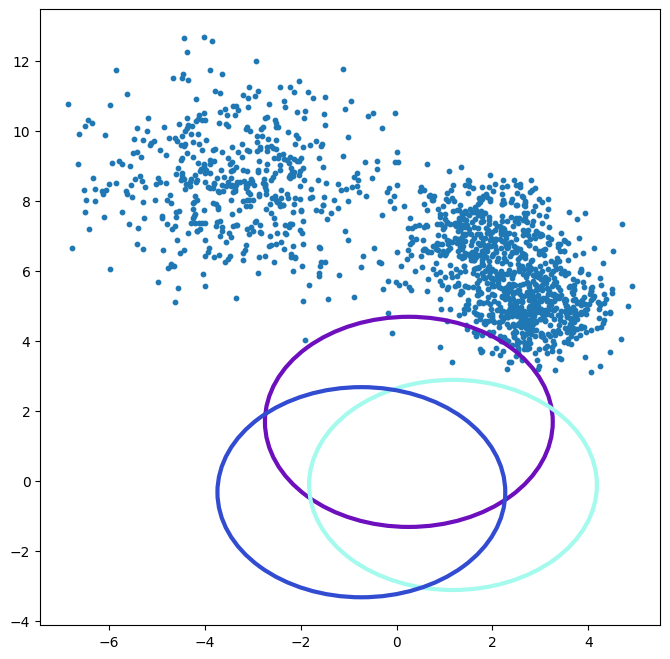

In [19]:
def init_random_params(cluster_amount, dim):
    """
    Функция задания начальных параметров для GMM
    input:
    - cluster_amount: Количество кластеров
    - dim: Размерность точек
    output:
    - params: словарь начальных параметров для GMM
    """
    # априорное веротяностей распределение по кластерам
    uniform_distr = np.random.uniform(0, 1, cluster_amount)
    initial_claster_distribution = uniform_distr / uniform_distr.sum()
    
    # начальное распределение для средних кластеров
    initial_mean_distribution = np.random.normal(0, 1, (cluster_amount, dim))
       
    # массив матриц ковариации для кластеров
    cluster_cov_matrix = np.zeros((cluster_amount, dim, dim))
    for i in range(cluster_amount):
        cluster_cov_matrix[i] = np.eye(dim)
    
    params = {
        "pi": initial_claster_distribution,
        "mu": initial_mean_distribution,
        "sigma": cluster_cov_matrix
    }
    return params

def test():
    cluster_amount = 3
    data_dim = 2

    gmm_data = generate_gm_data(k=cluster_amount, dim=data_dim, 
                                points_per_cluster=500, do_spheres=True) 

    init_gaussians_rand_params = init_random_params(cluster_amount, data_dim)

    mu_array = init_gaussians_rand_params['mu']
    sigma_array = init_gaussians_rand_params['sigma']
    cluster_colors = np.random.rand(cluster_amount, 3)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    ax.scatter(gmm_data[:, 0], gmm_data[:, 1], s=10)

    for i in range(cluster_amount):
        plot_gaussian(mu_array[i], sigma_array[i], ax, cluster_colors[i])
        
test()

### KNN Algoritm

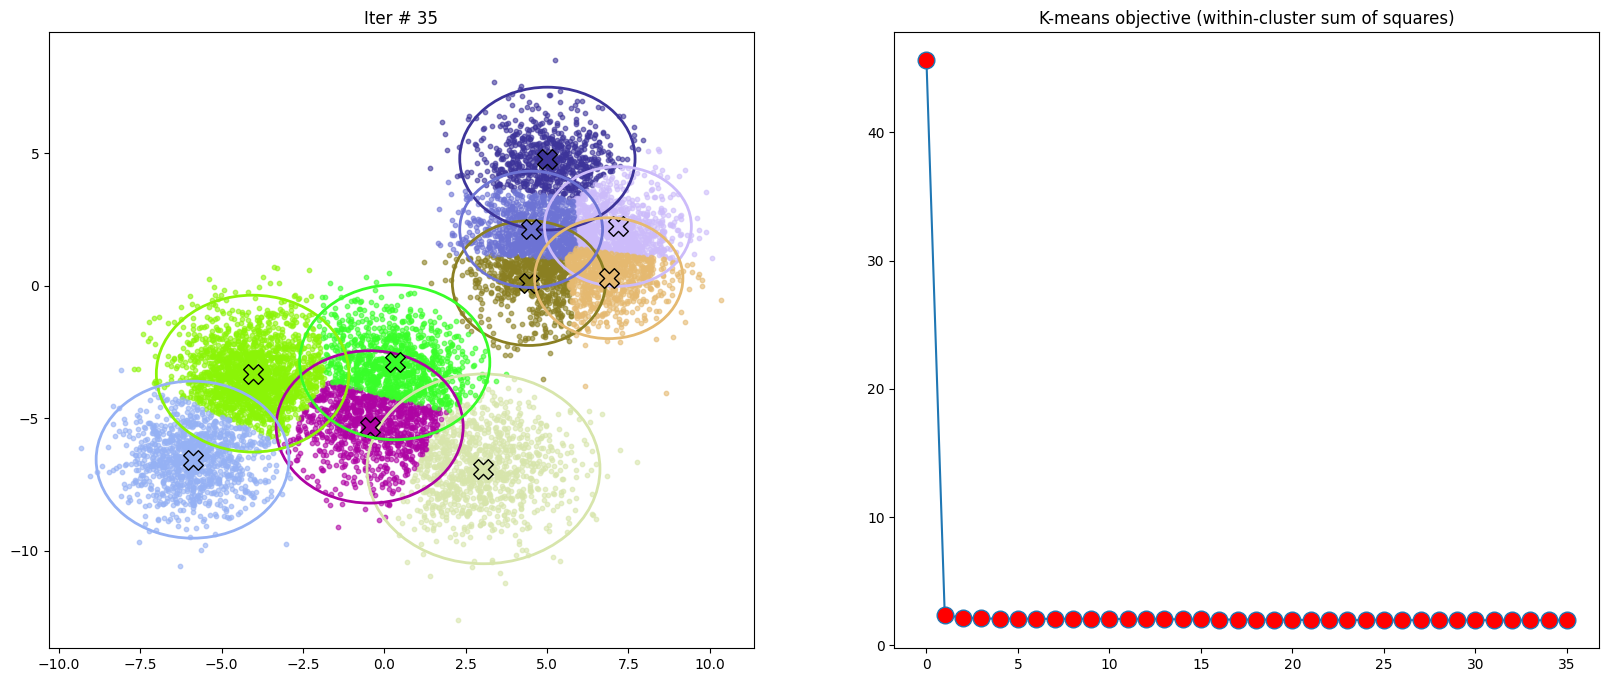

Внутрикластерное расстояние до обучения:  45.62331373552448
Внутрикластерное расстояние после обучения:  1.945954107618326


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

class KMeans_clusterization:
    """
    Имплементация K-means (k-средних)
    """
    def __init__(self, cluster_amount, points_array, cluster_color):
        # количество кластеров
        self.cluster_amount = cluster_amount
        
        # данные для кластеризации
        self.points_array = np.array(points_array)
        
        # размерность точек
        self.dim = self.points_array.shape[1]
        
        # начальная инициализация центров кластеров
        # (случайный выбор точек из датасета)
        indices = np.random.choice(len(self.points_array), self.cluster_amount, replace=False)
        self.centroids = self.points_array[indices]
        
        # порог на разность сходимости 
        self.convergance_tol = 1e-4
        
        # принадлежность каждой точки к кластеру (жёсткое отнесение)
        self.labels = np.zeros(len(self.points_array), dtype=int)
        
        # цвета кластеров (для визуализации)
        self.cluster_colors = cluster_color
        
    def e_step(self):
        """
        E-шаг для k-means:
        для каждой точки находим ближайший центр (жёсткое отнесение кластерам)
        """
        # считаем расстояния от всех точек до всех центров
        # points: (N, dim), centroids: (K, dim)
        # получим матрицу расстояний (N, K)
        # 
        #for i in range(N):
            # for j in range(K):
            #     diff[i, j, :] = self.points_array[i] - self.centroids[j]
        diff = self.points_array[:, None, :] - self.centroids[None, :, :]  # (N, 1, dim) - (1, K, dim) = (N, K, dim)
        # получаем для каждой точки ее растояние до каждого кластера
        dist_sq = np.sum(diff ** 2, axis=2)  # (N, K)
        
        # для каждой точки выбираем ближайший центр
        self.labels = np.argmin(dist_sq, axis=1)
        
        # вернём количество точек в каждом кластере
        counts = np.bincount(self.labels, minlength=self.cluster_amount)
        return counts
    
    def m_step(self, counts):
        """
        M-шаг для k-means:
        обновляем центры кластеров как среднее точек,
        отнесённых к каждому кластеру.
        """
        for k in range(self.cluster_amount):
            # точки, попавшие в кластер k
            cluster_points = self.points_array[self.labels == k]
            if len(cluster_points) > 0:
                # новое мат. ожидание = среднее точек кластера
                self.centroids[k] = cluster_points.mean(axis=0)
            else:
                # если кластер опустел, переинициализируем центр
                self.centroids[k] = self.points_array[np.random.randint(len(self.points_array))]
    
    def draw(self, ax, n_std=2.0):
        """
        Для двумерного датасета изобразим k-средних:
        - центр кластера (X)
        - окружность вокруг центра, задающая "радиус" кластера.
        K-means не моделирует ковариации, поэтому используем
        средний радиус точек кластера как меру размера.
        """
        if self.dim != 2:
            print("Изображение только для двумерного случая.")
            return
        
        for k in range(self.cluster_amount):
            # рисуем центр кластера
            cx, cy = self.centroids[k]
            ax.scatter(cx, cy, c=self.cluster_colors[k], 
                    s=200, edgecolor='k', marker='X')
            
            # берём точки, отнесённые к этому кластеру
            cluster_points = self.points_array[self.labels == k]
            if len(cluster_points) == 0:
                continue  # если кластер пустой, пропускаем

            # считаем средний квадрат расстояния до центра
            diff = cluster_points - self.centroids[k]
            dist_sq = np.sum(diff ** 2, axis=1)
            # среднеквадратичное отклонение радиуса
            radius = np.sqrt(np.mean(dist_sq)) * n_std

            # рисуем окружность вокруг центра
            circle = patches.Circle(
                (cx, cy),
                radius=radius,
                fill=False,
                edgecolor=self.cluster_colors[k],
                lw=2
            )
            ax.add_patch(circle)
    
    def objective(self):
        """
        Функция стоимости k-means:
        сумма квадратов расстояний до ближайшего центра
        (аналог отрицательного логарифма правдоподобия в GMM)
        """
        diff = self.points_array - self.centroids[self.labels]
        dist_sq = np.sum(diff ** 2, axis=1)
        return np.mean(dist_sq)
    
    def plot_training(self, title_str, objective_list):
        """"
        График текущего статуса тренировки
        """
        # создадим 2 объекта plt
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        
        # на ax1 добавим сгенерированные точки, раскрашенные по текущим меткам
        if self.dim == 2:
            for k in range(self.cluster_amount):
                pts = self.points_array[self.labels == k]
                ax1.scatter(pts[:, 0], pts[:, 1], s=10, 
                            color=self.cluster_colors[k], alpha=0.6)
        else:
            ax1.scatter(self.points_array[:, 0], self.points_array[:, 1], s=10)
        
        # нарисуем центры кластеров
        self.draw(ax1)
        ax1.set_title(title_str)
        
        # на ax2 изобразим график сходимости (уменьшение функции стоимости)
        ax2.plot(range(len(objective_list)), objective_list, 
                 marker='o', markerfacecolor='red', markersize=12)
        ax2.set_title('K-means objective (within-cluster sum of squares)')
        
        plt.show()
    
    def fit_kmeans(self):
        """
        Функция обучения k-means
        """
        objective_history = [self.objective()]
        improved = True
        i = 0
        
        while improved:
            clear_output(True)
            prev_obj = objective_history[-1]
            
            self.plot_training(f'Iter # {i}', objective_history)
            
            counts = self.e_step()
            self.m_step(counts)
            
            curr_obj = self.objective()
            objective_history.append(curr_obj)
            
            if np.abs(prev_obj - curr_obj) < self.convergance_tol:
                improved = False
            
            i += 1
            time.sleep(0.25)
        
        print('Внутрикластерное расстояние до обучения: ', objective_history[0])
        print('Внутрикластерное расстояние после обучения: ', objective_history[-1])

cluster_amount = 10
data_dim = 2
cluster_colors = np.random.rand(cluster_amount, 3)

gmm_data = generate_gm_data(k=cluster_amount, dim=data_dim, points_per_cluster=1000, do_spheres=True)

kmeans = KMeans_clusterization(cluster_amount, gmm_data, cluster_colors)
kmeans.fit_kmeans()


### EM алгоритм

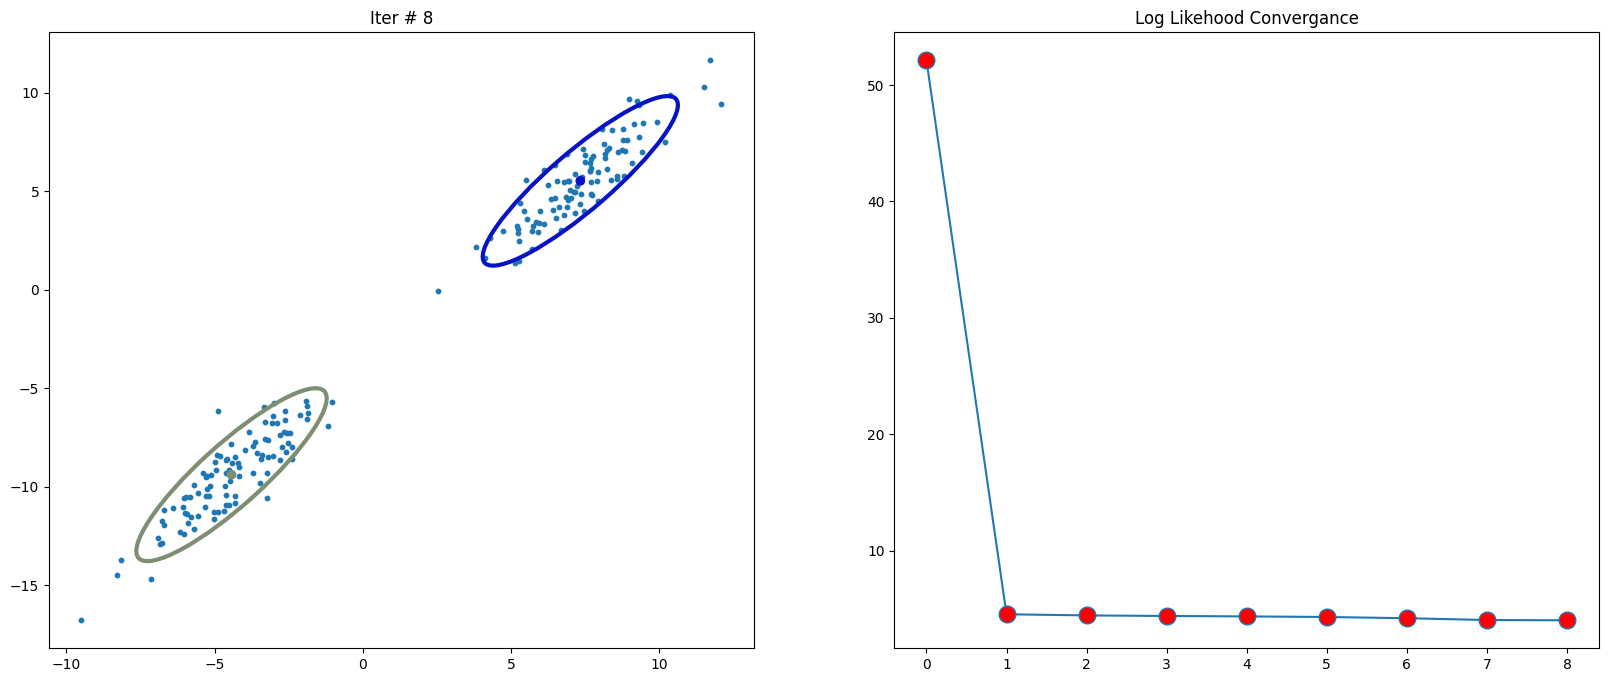

Вероятности отнесения к классу до обучения:  [0.81142832 0.18857168]
Вероятности отнесения к классу после обучения:  [0.49998193 0.50001807]


In [21]:
class EM_clusterization:
    """
    Имплементация EM для GMM
    """
    def __init__(self, cluster_amount, points_array, cluster_color):
        # количество кластеров
        self.cluster_amount = cluster_amount
        
        # данные для кластеризации
        self.points_array = np.array(points_array)
        
        # размерность точек
        self.dim = self.points_array.shape[1]
        
        # инициализация начальных данных
        self.params = init_random_params(self.cluster_amount, self.dim)
        
        # порог на разность сходимости 
        self.convergance_tol = 0.0001
        
        #вектор изначальных веротяностей(prior) отнесения к кластеру  
        self.pi = self.params['pi']
        
        # список векторов мат. ожидания кластера
        self.mu_array = self.params['mu']
        
        # список матриц ковариации кластеров
        self.sigma_array = self.params['sigma']
        
        # матрица веротяностей отнесения каждой точки к каждому кластеру
        self.gamma = np.zeros((len(points_array), self.cluster_amount))
        
        # цвета гауссиан
        self.cluster_colors = cluster_color
        
    def e_step(self):
        # для каждого кластера рассчитываем p(z, x) - делаем это в векторной форме для каждой точки
        for i in range(self.cluster_amount):
            self.gamma[:, i] = self.pi[i] * multivariate_normal.pdf(self.points_array, mean=self.mu_array[i], cov=self.sigma_array[i])
        # делим на p(x)
        self.gamma = self.gamma / self.gamma.sum(axis=1, keepdims=True)# shape - (N, cluster_amount)
        # также нужно рассчитать общую сумму вероятностей на каждый класс для пересчета априорного распределения pi
        per_cluster_prob_sum = self.gamma.sum(axis=0)# shape - (1, cluster_amount)
        return per_cluster_prob_sum
    
    def m_step(self, per_cluster_prob_sum):
        # сумму вероятностей по каждому кластеру разделим на общее количество точек - новое априорное распределение на кластер
        self.pi = per_cluster_prob_sum / len(self.points_array)# shape - (1, cluster_amount)
        # рассчитаем новое мат. ожидание 
        self.mu_array = np.matmul(self.gamma.T, self.points_array) / per_cluster_prob_sum[:, None]# shape - (cluster_amount, dim)
        # рассчитаем для новую матрицу ковариации для каждого кластера
        for i in range(self.cluster_amount):
            diff = np.expand_dims(self.points_array, axis=1) - self.mu_array[i]
            squared = np.matmul(diff.transpose([0, 2, 1]), diff)
            self.sigma_array[i] = np.matmul(squared.transpose(1, 2, 0), self.gamma[:, i])
            self.sigma_array[i] = self.sigma_array[i] / per_cluster_prob_sum[i]# shape - (dim, dim), всего cluster_amount матриц
    

    def draw(self, ax, n_std=2.0, facecolor='none'):
        """
        Для двумерного датасета изобразим k гауссиан на данной итерации.
        """
        if(self.dim != 2):
            print("Изображение только для двумерного случая.")
            return
        # послеждовательно рисуем гауссианы
        for i in range(self.cluster_amount):
            plot_gaussian(self.mu_array[i], self.sigma_array[i], 
                        ax, n_std=n_std, edgecolor=self.cluster_colors[i])
    
    
    def plot_training(self, title_str, log_likehood_list):
        """"
        График текущего статуса тренировки
        """
        # создадим 2 объекта plt
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        
        # на ax1 добавим сгенерированные точки
        ax1.scatter(self.points_array[:, 0], self.points_array[:, 1], s=10)
        # поставим точки центров кластеров
        ax1.scatter(self.mu_array[:, 0], self.mu_array[:, 1], c=self.cluster_colors)
        # нарисуем сами эллипсы
        self.draw(ax1)
        ax1.set_title(title_str)
        
        # на ax2 изобразим график сходимости 
        ax2.plot(range(len(log_likehood_list)), log_likehood_list, marker='o', markerfacecolor='red', markersize=12)
        ax2.set_title('Log Likehood Convergance')
        
        plt.show()
        
            
            
    def log_likelihood(self, data_points):
        """
        Функция рассчета отрицательного логарифма правдоподобия на данных обучения
        """
        log_likelihood_array = []
        # для каждой точки в датасете, считаем сумму отрицательных логарифмов правдоподобия p(x,z)
        for sample in data_points:
            total_prob_per_point = 0
            for i in range(self.cluster_amount):
                total_prob_per_point += self.pi[i] * multivariate_normal.pdf(sample, mean=self.mu_array[i], cov=self.sigma_array[i])
            log_likelihood_array.append(-np.log(total_prob_per_point))
        avg_log_likehood = np.sum(log_likelihood_array) / len(data_points)
        return avg_log_likehood
            
            
    def fit_em(self):
        """
        Функция обучения EM GMM алгоритма
        """
        # история сходимости алгоритма
        log_likelihood_history = [gmm.log_likelihood(self.points_array)]
        improved = True
        i = 0
        old_pi = self.pi
        while improved:
            clear_output(True)
            prev_ll = log_likelihood_history[-1]
            
            self.plot_training(f'Iter # {i}', log_likelihood_history)
            
            n = gmm.e_step()
            gmm.m_step(n)
            
            curr_ll = gmm.log_likelihood(self.points_array)
            log_likelihood_history.append(curr_ll)
            
            if np.abs(curr_ll - prev_ll) < self.convergance_tol:
                improved = False
            
            i += 1
            
            time.sleep(0.25)
            
        print('Вероятности отнесения к классу до обучения: ', old_pi)
        print('Вероятности отнесения к классу после обучения: ', self.pi)
            
cluster_amount = 2
data_dim = 2
cluster_colors = np.random.rand(cluster_amount, 3)

gmm_data = generate_gm_data(k=cluster_amount, dim=data_dim, 
                            points_per_cluster=100)            
gmm = EM_clusterization(cluster_amount, gmm_data, cluster_colors)
gmm.fit_em()

In [22]:
# пример рассчета апостериорной вероятности отношения объекту к кластеру

import math
from scipy.stats import norm

point = 2
cluster_1 = norm(loc=1, scale=1**0.5)
cluster_2 = norm(loc=2, scale=0.5**0.5)

first_prob = 0.5 * cluster_1.pdf(point) / (0.5 * cluster_1.pdf(point) + 0.5 * cluster_2.pdf(point))
second_prob = 0.5 * cluster_2.pdf(point) / (0.5 * cluster_1.pdf(point) + 0.5 * cluster_2.pdf(point))

round(first_prob, 2), round(second_prob, 2)

(np.float64(0.3), np.float64(0.7))